#### Objetivo: generar un modelo que pueda hacer predicciones de ventas

#### Escenario: Eres un científico de datos dentro de la consultoría “El oráculo”, tienes la asignación de trabajar en una empresa de retail para predecir sus ventas semanales a diferentes niveles muestrales, a nivel tienda

#### Datasource: https://www.kaggle.com/code/aslanahmedov/walmart-sales-forecasting

#### Entrega: 06 de Agosto de 2022



# 1. Import Libraries

In [280]:
import pandas as pd
import numpy as np
from prophet import Prophet
import plotly.express as px
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARMA
import math

from statsmodels.tsa.stattools import adfuller

# 2. Read Data

In [281]:
df = pd.read_csv('c:/Users/mike_/Documents/repos/walmart_forecast/data/clean_data.csv', parse_dates=['Date'])
#df = pd.read_csv('https://raw.githubusercontent.com/lebesguee/walmart_forecast/main/data/clean_data.csv',\
 #               parse_dates=['Date']) # read online

## leer desde google drive: codigo en repo

# 2. EDA

In [282]:
df.sample(10)

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
328492,329469,34,91,2012-06-22,37911.06,False,78.85,3.329,4673.00,169.00,...,9.575,A,158114,False,False,False,False,25,6,2012
85323,85480,9,23,2012-03-16,9963.82,False,59.94,3.734,1913.05,1.80,...,5.667,B,125833,False,False,False,False,11,3,2012
159250,159695,17,79,2010-09-17,28085.18,False,58.53,2.875,0.00,0.00,...,6.697,B,93188,False,False,False,False,37,9,2010
239955,240706,25,74,2011-02-04,9846.70,False,23.94,3.231,0.00,0.00,...,7.343,B,128107,False,False,False,False,5,2,2011
52004,52091,6,37,2010-12-24,3913.89,False,55.07,2.886,0.00,0.00,...,7.007,A,202505,False,False,False,False,51,12,2010
392603,393857,42,93,2011-03-25,28354.49,False,62.53,3.716,0.00,0.00,...,8.744,C,39690,False,False,False,False,12,3,2011
310091,311036,32,55,2012-01-06,8379.78,False,36.75,3.095,4323.27,33209.84,...,8.256,A,203007,False,False,False,False,1,1,2012
291424,292301,30,52,2012-04-13,21.66,False,69.03,3.891,48.96,856.15,...,6.891,C,42988,False,False,False,False,15,4,2012
6705,6716,1,80,2011-11-18,19646.97,False,62.25,3.308,6074.12,254.39,...,7.866,A,151315,False,False,False,False,46,11,2011
209506,210173,22,72,2010-12-10,88711.46,False,28.43,3.132,0.00,0.00,...,8.572,B,119557,False,False,False,False,49,12,2010


In [283]:
print('rows =', df.shape[0], ', columns =' ,df.shape[1]) # dataset shape

rows = 420212 , columns = 24


In [284]:
df.groupby('Store')['Temperature'].mean() # temperature by store

Store
1     68.229523
2     68.112759
3     71.291182
4     62.175089
5     69.197526
6     69.661825
7     39.614959
8     62.446207
9     67.648123
10    72.134232
11    72.460626
12    70.151123
13    53.589600
14    57.784116
15    51.744722
16    44.990735
17    46.353329
18    53.267738
19    52.207925
20    55.341567
21    68.778463
22    54.850533
23    48.777486
24    53.977504
25    52.113704
26    43.624179
27    57.304085
28    70.164762
29    54.866579
30    68.791359
31    68.812141
32    52.692604
33    76.806956
34    58.413646
35    57.297088
36    71.194607
37    71.245133
38    70.368641
39    70.584149
40    47.589667
41    48.393676
42    72.267767
43    68.872408
44    53.899992
45    57.772233
Name: Temperature, dtype: float64

In [285]:
df.loc[df['Store'] == 1] # size constant through stores

,Unnamed: 0,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,...,8.106,A,151315,False,False,False,False,5,2,2010
1,1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.00,0.00,...,8.106,A,151315,False,False,False,False,5,2,2010
2,2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.00,0.00,...,8.106,A,151315,False,False,False,False,5,2,2010
3,3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.00,0.00,...,8.106,A,151315,False,False,False,False,5,2,2010
4,4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.00,0.00,...,8.106,A,151315,False,False,False,False,5,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10221,10239,1,94,2012-10-26,60278.73,False,69.16,3.506,2585.85,31.75,...,6.573,A,151315,False,False,False,False,43,10,2012
10222,10240,1,95,2012-10-26,117375.38,False,69.16,3.506,2585.85,31.75,...,6.573,A,151315,False,False,False,False,43,10,2012
10223,10241,1,96,2012-10-26,36851.92,False,69.16,3.506,2585.85,31.75,...,6.573,A,151315,False,False,False,False,43,10,2012
10224,10242,1,97,2012-10-26,32830.52,False,69.16,3.506,2585.85,31.75,...,6.573,A,151315,False,False,False,False,43,10,2012


In [286]:
df.groupby('Store')['Size'].mean() # temperature by store

Store
1     151315.0
2     202307.0
3      37392.0
4     205863.0
5      34875.0
6     202505.0
7      70713.0
8     155078.0
9     125833.0
10    126512.0
11    207499.0
12    112238.0
13    219622.0
14    200898.0
15    123737.0
16     57197.0
17     93188.0
18    120653.0
19    203819.0
20    203742.0
21    140167.0
22    119557.0
23    114533.0
24    203819.0
25    128107.0
26    152513.0
27    204184.0
28    206302.0
29     93638.0
30     42988.0
31    203750.0
32    203007.0
33     39690.0
34    158114.0
35    103681.0
36     39910.0
37     39910.0
38     39690.0
39    184109.0
40    155083.0
41    196321.0
42     39690.0
43     41062.0
44     39910.0
45    118221.0
Name: Size, dtype: float64

In [287]:
#TO DO: Add PowerBI Viz 

In [288]:
#print('rows =', df.shape[0], ', columns =' ,df.shape[1]) # dataset shape
#df.columns #dataset columns
#df.sample(10) #df sample size 10
#df.info() # datatypes and null count
#df['Unnamed: 0'].duplicated().sum() # The Unnamed: 0 is the ID, no duplicates are expected
#df[df.duplicated('Unnamed: 0')] # no duplicates in ID confirmed
#df.describe() #quick stats summary

In [289]:
round(df.isnull().sum().sort_values(ascending=False)*100/len(df), 4) # Porcentaje Descendente de Nulos por Columna
#df.isnull().sum().sort_values(ascending=False) # Conteo Descendente de Nulos por Columna

Unnamed: 0      0.0
Store           0.0
month           0.0
week            0.0
Christmas       0.0
Thanksgiving    0.0
Labor_Day       0.0
Super_Bowl      0.0
Size            0.0
Type            0.0
Unemployment    0.0
CPI             0.0
MarkDown5       0.0
MarkDown4       0.0
MarkDown3       0.0
MarkDown2       0.0
MarkDown1       0.0
Fuel_Price      0.0
Temperature     0.0
IsHoliday       0.0
Weekly_Sales    0.0
Date            0.0
Dept            0.0
year            0.0
dtype: float64

# 3. Tables Creation

### 3.1 Tabla: Total de Ventas por Tienda

In [290]:
TOTAL_SALES_BY_STORE = df.groupby('Store', sort=False)["Weekly_Sales"].sum().reset_index(name ='Total_Sales')
#TOTAL_SALES_BY_STORE.head(10)

# Uncomment to get Table in Currency Format
#TOTAL_SALES_BY_STORE_STR = df.groupby('Store', sort=False)["Weekly_Sales"].sum().reset_index(name ='Total_Sales')
#TOTAL_SALES_BY_STORE_STR['Total_Sales'] = TOTAL_SALES_BY_STORE['Total_Sales'].map("${:,.2f}".format) # formato moneda
#TOTAL_SALES_BY_STORE_STR.head(10)

TOP10_SALES_STORES = TOTAL_SALES_BY_STORE.sort_values(by=['Total_Sales'], ascending=False).reset_index(drop=True).head(10)
TOP1_SALES_STORE = TOTAL_SALES_BY_STORE.sort_values(by=['Total_Sales'], ascending=False).reset_index(drop=True).head(1) # top n=1 tiendas con más ventas
TOP1_SALES_STORE['Total_Sales'] = TOP1_SALES_STORE['Total_Sales'].map("${:,.2f}".format)
TOP1_SALES_STORE

,Store,Total_Sales
0,20,"$301,401,381.45"


### 3.2 Tablas: Varianza por Tienda y Desviación Estándar por Tienda

In [291]:
VARIANCE_BY_STORE = df.groupby('Store', sort=False)["Weekly_Sales"].var().reset_index(name ='Sales_Variance')
STD_BY_STORE = df.groupby('Store', sort=False)["Weekly_Sales"].std().reset_index(name ='Sales_STD')# efectivo: sacar raiz a varianza

#VARIANCE_BY_STORE.head(10)
#STD_BY_STORE.head(10)

TOP1_STD_BY_STORE = STD_BY_STORE.sort_values(by=['Sales_STD'], ascending=False).reset_index(drop=True).head(1) # top n=1 tiendas con más ventas
TOP1_STD_BY_STORE['Sales_STD'] = TOP1_STD_BY_STORE['Sales_STD'].map("${:,.2f}".format)
TOP1_STD_BY_STORE

,Store,Sales_STD
0,14,"$36,936.12"


### 3.3 Coeficiente de Variación Medio

In [292]:
cv = lambda x: np.std(x.values) / np.mean(x.values) * 100
CV_BY_STORE = df[["Store","Weekly_Sales"]].groupby("Store").apply(cv).reset_index(name ='Coefficient_of_Variation')

TOP10_CV_BY_STORE = CV_BY_STORE.sort_values(by=['Coefficient_of_Variation'], ascending=False).reset_index(drop=True).head(10) # top n=1 tiendas con más ventas
TOP10_CV_BY_STORE['Coefficient_of_Variation'] = TOP10_CV_BY_STORE['Coefficient_of_Variation'].map("${:,.2f}".format)
TOP10_CV_BY_STORE

#CV_BY_STORE['Coefficient_of_Variation'].mean() # Promedio de Coeficiente de Variación

,Store,Coefficient_of_Variation
0,3,$331.28
1,44,$265.03
2,38,$258.57
3,30,$251.08
4,5,$246.31
5,42,$244.80
6,37,$243.93
7,33,$241.23
8,43,$239.68
9,36,$234.56


### 3.4 Vista Mensual, Trimestral y Semestral de Ventas Totales y por Tienda 

In [293]:
TOTAL_SALES_BY_MONTH = pd.DataFrame(df.set_index('Date')['Weekly_Sales'].resample('M').sum().reset_index(name ='Monthly_Sales'))
TOTAL_SALES_BY_QUARTER = pd.DataFrame(df.set_index('Date')['Weekly_Sales'].resample('Q').sum().reset_index(name ='Quarterly_Sales'))
TOTAL_SALES_BY_SEMESTER = pd.DataFrame(df.set_index('Date')['Weekly_Sales'].resample('2BQ').sum().reset_index(name ='Semester_Sales'))

#TOTAL_SALES_BY_MONTH.head(10)
#TOTAL_SALES_BY_QUARTER.head(10)
#TOTAL_SALES_BY_SEMESTER.head(10)

MONTHLY_SALES_BY_STORE = df.set_index("Date").groupby([pd.Grouper(freq="M"), "Store"])['Weekly_Sales'].sum().reset_index().rename(columns = {'Weekly_Sales':'Total_Sales'})
QUARTERLY_SALES_BY_STORE = df.set_index("Date").groupby([pd.Grouper(freq="Q"), "Store"])['Weekly_Sales'].sum().reset_index().rename(columns = {'Weekly_Sales':'Total_Sales'})
SEMESTER_SALES_BY_STORE = df.set_index("Date").groupby([pd.Grouper(freq="2BQ"), "Store"])['Weekly_Sales'].sum().reset_index().rename(columns = {'Weekly_Sales':'Total_Sales'})

#MONTHLY_SALES_BY_STORE
#SEMESTER_SALES_BY_STORE.head(20)
#MONTHLY_SALES_BY_STORE['Date'].max()
#MONTHLY_SALES_BY_STORE['Date'].min()
# MONTHLY_SALES_BY_STORE['Date'].sort_values(ascending=True)

In [294]:
WEEKLY_SALES_BY_STORE = df.set_index("Date").groupby([pd.Grouper(freq="W"), "Store"])['Weekly_Sales'].sum().reset_index().rename(columns = {'Weekly_Sales':'Total_Sales'})

In [295]:
WEEKLY_SALES_BY_STORE

,Date,Store,Total_Sales
0,2010-02-07,1,1643690.90
1,2010-02-07,2,2136989.46
2,2010-02-07,3,461622.22
3,2010-02-07,4,2135143.87
4,2010-02-07,5,317173.10
...,...,...,...
6430,2012-10-28,41,1316542.59
6431,2012-10-28,42,514758.55
6432,2012-10-28,43,587603.55
6433,2012-10-28,44,361067.07


In [296]:
MONTHLY_SALES_BY_STORE

,Date,Store,Total_Sales
0,2010-02-28,1,6308207.10
1,2010-02-28,2,8264347.77
2,2010-02-28,3,1711198.23
3,2010-02-28,4,8299040.36
4,2010-02-28,5,1202728.00
...,...,...,...
1480,2012-10-31,41,5452445.75
1481,2012-10-31,42,2261906.96
1482,2012-10-31,43,2473507.39
1483,2012-10-31,44,1360020.41


### 3.5 Vista Mensual, Trimestral y Semestral de Ventas Totales y por Tienda con Tasa de Crecimiento

In [297]:
MONTHLY_SALES_BY_STORE_W_RATE = MONTHLY_SALES_BY_STORE.assign(Growth_Rate=MONTHLY_SALES_BY_STORE['Total_Sales'].pct_change())
QUARTERLY_SALES_BY_STORE_W_RATE = QUARTERLY_SALES_BY_STORE.assign(Growth_Rate=QUARTERLY_SALES_BY_STORE['Total_Sales'].pct_change())
SEMESTER_SALES_BY_STORE_W_RATE = SEMESTER_SALES_BY_STORE.assign(Growth_Rate=SEMESTER_SALES_BY_STORE['Total_Sales'].pct_change())

#MONTHLY_SALES_BY_STORE_W_RATE

In [298]:
MONTHLY_SALES_BY_STORE_W_RATE

,Date,Store,Total_Sales,Growth_Rate
0,2010-02-28,1,6308207.10,NaN
1,2010-02-28,2,8264347.77,0.310095
2,2010-02-28,3,1711198.23,-0.792942
3,2010-02-28,4,8299040.36,3.849842
4,2010-02-28,5,1202728.00,-0.855076
...,...,...,...,...
1480,2012-10-31,41,5452445.75,0.401271
1481,2012-10-31,42,2261906.96,-0.585157
1482,2012-10-31,43,2473507.39,0.093550
1483,2012-10-31,44,1360020.41,-0.450165


# 4. Modeling

### 4.1 Forecast Regresión Lineal

The training dataset has 120 records, ranging from 2010-02-07 00:00:00 to 2012-05-20 00:00:00
The testing dataset has 23 records, ranging from 2012-05-27 00:00:00 to 2012-10-28 00:00:00
Coefficients: 
 [1242.64754226]
Mean squared error: 12501688526.01
Coefficient of determination: -0.87


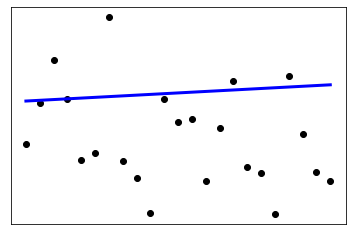

In [299]:
# Prepare data of Store 1
_STORE_1_SERIES = WEEKLY_SALES_BY_STORE[WEEKLY_SALES_BY_STORE['Store']==1] #filter Store1
STORE_1_SERIES = _STORE_1_SERIES[['Date', 'Total_Sales']].rename(columns={'Date':'Date', 'Total_Sales':'Total_Sales'})\
                                                         .reset_index()\
                                                         .drop(['index'], axis=1)#.set_index('Date') # create Store1 table
STORE_1_SERIES['Time'] = np.arange(len(STORE_1_SERIES.index)) # add time step column

#https://medium.com/@Hong_Tang/timeseries-split-with-sklearn-tips-8162c83612b9

# Time Series Split
tscv = TimeSeriesSplit() # instantiate object from class. default parameter sets object to perform k=5 splits

# Set date as index
STORE_1_SERIES.set_index('Date', inplace=True)
STORE_1_SERIES.sort_index(inplace=True)

#prepare features dataframe (X) and target (y) as data series
X = STORE_1_SERIES.drop(labels=['Total_Sales'], axis=1)
y = STORE_1_SERIES['Total_Sales']

# Split train test sets for both features and targets time-series class (tscv) class returns two arrays to mark train and test sets
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Uncomment to show a plot with the results of the split train test
#y_train.groupby('Date').mean().plot()
#y_test.groupby('Date').mean().plot()

# Summary of Train Test Split: number of records and date range for training and testing dataset.
print('The training dataset has', len(X_train), 'records, ranging from', pd.DataFrame(y_train).index.min(), 'to', pd.DataFrame(y_train).index.max())
print('The testing dataset has', len(X_test), 'records, ranging from', pd.DataFrame(y_test).index.min(), 'to', pd.DataFrame(y_test).index.max())

#https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train.values, y_train.values)

# Make predictions using the testing set
y_pred = regr.predict(X_test.values)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % metrics.mean_squared_error(y_test.values, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % metrics.r2_score(y_test.values, y_pred))

# Plot outputs
plt.scatter(X_test.values, y_test.values, color="black")
plt.plot(X_test.values, y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [300]:
# function to evaluate metrics
def evaluate(y_true, y_pred):
    dict = {
        'MAE': metrics.mean_absolute_error(y_true, y_pred),
        'MSE': metrics.mean_squared_error(y_true, y_pred),
        'RMSE': math.sqrt(metrics.mean_squared_error(y_true, y_pred)),
        'R2': metrics.r2_score(y_true, y_pred)
        }
    return dict

# model performance
evaluate(y_test.values, y_pred)

{'MAE': 93594.25616272884,
 'MSE': 12501688526.009594,
 'RMSE': 111810.94993787323,
 'R2': -0.8738924620234421}

<AxesSubplot:xlabel='Date'>

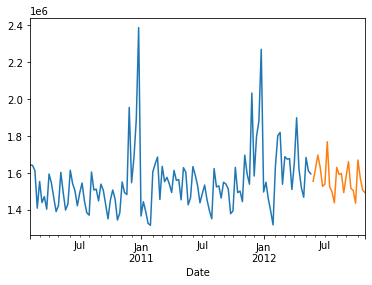

In [301]:
# Uncomment to show a plot with the results of the split train test
y_train.groupby('Date').mean().plot()
y_test.groupby('Date').mean().plot()

In [302]:
# Prepare data of Store 1
_STORE_1_SERIES = WEEKLY_SALES_BY_STORE[WEEKLY_SALES_BY_STORE['Store']==1] #filter Store1
STORE_1_SERIES = _STORE_1_SERIES[['Date', 'Total_Sales']].rename(columns={'Date':'Date', 'Total_Sales':'Total_Sales'})\
                                                         .reset_index()\
                                                         .drop(['index'], axis=1)#.set_index('Date') # create Store1 table

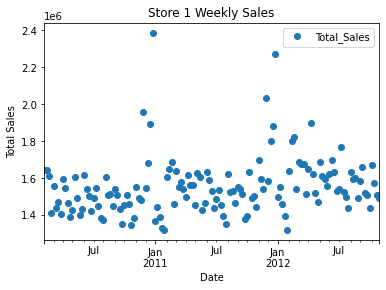

In [303]:
#matplotlib scatterplot
STORE_1_SERIES.plot(x='Date', y='Total_Sales', style='o')
plt.title('Store 1 Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

In [304]:
#plotly scatterplot
fig = px.scatter(STORE_1_SERIES, x="Date", y="Total_Sales")#, trendline="ols")
fig.show()

In [305]:
#plotly line
fig = px.line(STORE_1_SERIES, x="Date", y="Total_Sales")#, trendline="ols")
fig.show()

In [306]:
#  analyze the so-called log-returns, i.e. the day-to-day changes after a log-transformation of the series:
STORE_1_SERIES_logreturns = STORE_1_SERIES.assign(LogReturns = lambda x : STORE_1_SERIES['Total_Sales'].pct_change())
fig = px.line(STORE_1_SERIES_logreturns, x="Date", y="LogReturns")#, trendline="ols")
fig.show()

In [307]:
#Running this example shows that the mean and variance values are different, but in the same ball-park.

X = STORE_1_SERIES['Total_Sales'].values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=1528358.680694, mean2=1582604.813521
variance1=23356554589.061077, variance2=23503197166.342869


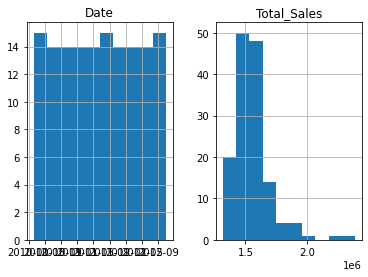

In [308]:
STORE_1_SERIES.hist()
plt.show()

In [309]:
fig = px.histogram(STORE_1_SERIES, x="Total_Sales")
fig.show()

In [310]:
fig = px.histogram(STORE_1_SERIES, x="Total_Sales", histnorm='probability density')
fig.show()

Reviewing the plot of the time series again, we can see that there is an obvious seasonality component, and it looks like the seasonality component is growing.

This may suggest an exponential growth from season to season. A log transform can be used to flatten out exponential change back to a linear relationship.

Below is the same histogram with a log transform of the time series.

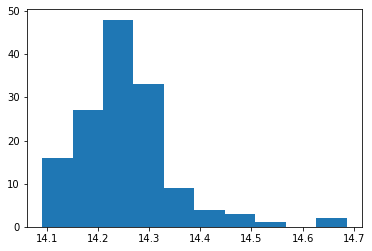

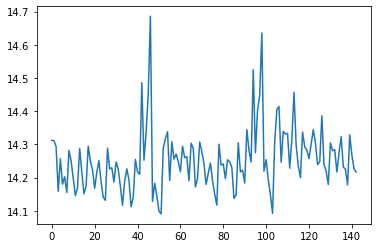

In [311]:
X = STORE_1_SERIES['Total_Sales'].values
X = np.log(X)
plt.hist(X)
plt.show()
plt.plot(X)
plt.show()

Augmented Dickey-Fuller test
Statistical tests make strong assumptions about your data. They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject. The result must be interpreted for a given problem to be meaningful.

Nevertheless, they can provide a quick check and confirmatory evidence that your time series is stationary or non-stationary.

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
Below is an example of calculating the Augmented Dickey-Fuller test on the Daily Female Births dataset. The statsmodels library provides the adfuller() function that implements the test.

In [312]:
X = STORE_1_SERIES['Total_Sales'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.102288
p-value: 0.000014
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


Running the example prints the test statistic value of -4. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -4 is less than the value of -3.479 at 1%.

This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

### 4.2 Forecast RNN

### 4.3 Prophet

In [313]:
#First the Store 1 Monthly Sales, then for all Stores
_STORE_1_SERIES = MONTHLY_SALES_BY_STORE_W_RATE[MONTHLY_SALES_BY_STORE_W_RATE['Store']==1] #filter Store1
STORE_1_SERIES = _STORE_1_SERIES[['Date', 'Total_Sales']].rename(columns={'Date':'ds', 'Total_Sales':'y'})\
                                                         .reset_index()\
                                                         .drop(['index'], axis=1) # create Store1 table
#STORE_1_SERIES.head(10)
#STORE_1_SERIES.info()

The training dataset has 28 records, ranging from 2011-01-31 00:00:00 to 2011-12-31 00:00:00
The testing dataset has 5 records, ranging from 2012-09-30 00:00:00 to 2012-06-30 00:00:00


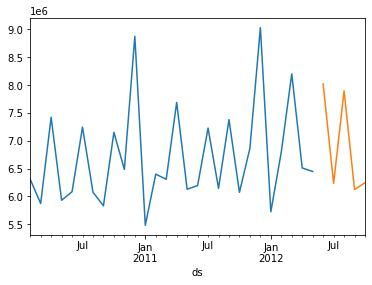

In [314]:
# Time Series Split

#https://medium.com/@Hong_Tang/timeseries-split-with-sklearn-tips-8162c83612b9

tscv = TimeSeriesSplit() # instantiate object from class

STORE_1_SERIES.set_index('ds', inplace=True) # set date as index
STORE_1_SERIES.sort_index(inplace=True) # sort ascending

#prepare features dataframe (X) and target (y) as data series
X = STORE_1_SERIES.drop(labels=['y'], axis=1)
y = STORE_1_SERIES['y']

# Split train test sets for both features and targets time-series class (tscv) class returns two arrays to mark train and test sets
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Result After the split, we can check the X_train and X_test data sets
# X_test index are younger than X_train
# X_test is greater than 2012 and X_train is older than 2012.
#X_train.index, X_test.index, y_train.index, y_test.index
#X_train, X_test, y_train, y_test

# Plot results
y_train.groupby('ds').mean().plot()
y_test.groupby('ds').mean().plot()

# Summary of Train Test Split: number of records and date range for training and testing dataset.
print('The training dataset has', len(X_train), 'records, ranging from', y_train.idxmin(), 'to', y_train.idxmax())
print('The testing dataset has', len(X_test), 'records, ranging from', y_test.idxmin(), 'to', y_test.idxmax())


#for arma model:
#rmse results list
#rmse = []
# arma model
#arma_model = ARMA(y_train.values, order=(0,1)).fit() # fit arma model with trian dataset
#predictions = model.predict(y_test.index.values[0], y_test.index.values[-1])
#true_values = y_test.values
#rmse.append(np.sqrt(metrics.mean_squared_error(true_values, predictions)))
#print(np.mean(rmse))

In [315]:
y_train.index

DatetimeIndex(['2010-02-28', '2010-03-31', '2010-04-30', '2010-05-31',
               '2010-06-30', '2010-07-31', '2010-08-31', '2010-09-30',
               '2010-10-31', '2010-11-30', '2010-12-31', '2011-01-31',
               '2011-02-28', '2011-03-31', '2011-04-30', '2011-05-31',
               '2011-06-30', '2011-07-31', '2011-08-31', '2011-09-30',
               '2011-10-31', '2011-11-30', '2011-12-31', '2012-01-31',
               '2012-02-29', '2012-03-31', '2012-04-30', '2012-05-31'],
              dtype='datetime64[ns]', name='ds', freq=None)

In [316]:
y_test.index

DatetimeIndex(['2012-06-30', '2012-07-31', '2012-08-31', '2012-09-30',
               '2012-10-31'],
              dtype='datetime64[ns]', name='ds', freq=None)

In [317]:
pd.DataFrame(y_train).reset_index()

,ds,y
0,2010-02-28,6308207.10
1,2010-03-31,5871991.98
2,2010-04-30,7422801.92
3,2010-05-31,5929938.64
4,2010-06-30,6084081.46
5,2010-07-31,7244483.04
6,2010-08-31,6075952.95
7,2010-09-30,5829793.92
8,2010-10-31,7150699.75
9,2010-11-30,6485547.06


In [318]:
#fit the model by instantiating a new Prophet object. Call fit method and pass in the train dataset
m = Prophet()
m.fit(pd.DataFrame(y_train).reset_index())

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\mike_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:prophet:n_changepoints greater than number of observations. Using 21.


In [319]:
""" 
predictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made
You can get a suitable dataframe that extends into the future a specified number of days using the helper
method Prophet.make_future_dataframe. By default it will also include the dates from the history, so we will see the model fit as well.
"""

future = m.make_future_dataframe(periods=5, freq='M') # predict next 12 months
future.tail(10)

,ds
23,2012-01-31
24,2012-02-29
25,2012-03-31
26,2012-04-30
27,2012-05-31
28,2012-06-30
29,2012-07-31
30,2012-08-31
31,2012-09-30
32,2012-10-31


In [320]:
"""
The predict method will assign each row in future a predicted value which it names yhat. If you pass in historical
 dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast,
  as well as columns for components and uncertainty intervals.
"""
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

c:\Users\mike_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\mike_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,ds,yhat,yhat_lower,yhat_upper
28,2012-06-30,6.713218e+06,6.545071e+06,6.911789e+06
29,2012-07-31,8.275147e+06,8.094902e+06,8.457014e+06
30,2012-08-31,7.033667e+06,6.864620e+06,7.204056e+06
31,2012-09-30,3.705543e+06,3.531479e+06,3.881550e+06
32,2012-10-31,1.015058e+07,9.963645e+06,1.032823e+07


In [321]:
forecast.sample(9)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
31,2012-09-30,6.897588e+06,3.531479e+06,3.881550e+06,6.897406e+06,6.897745e+06,-3.192045e+06,-3.192045e+06,-3.192045e+06,-3.192045e+06,-3.192045e+06,-3.192045e+06,0.0,0.0,0.0,3.705543e+06
25,2012-03-31,6.772937e+06,7.823215e+06,8.168405e+06,6.772937e+06,6.772937e+06,1.226971e+06,1.226971e+06,1.226971e+06,1.226971e+06,1.226971e+06,1.226971e+06,0.0,0.0,0.0,7.999908e+06
13,2011-03-31,6.523634e+06,5.860040e+06,6.214007e+06,6.523634e+06,6.523634e+06,-4.891489e+05,-4.891489e+05,-4.891489e+05,-4.891489e+05,-4.891489e+05,-4.891489e+05,0.0,0.0,0.0,6.034485e+06
30,2012-08-31,6.877154e+06,6.864620e+06,7.204056e+06,6.877036e+06,6.877250e+06,1.565133e+05,1.565133e+05,1.565133e+05,1.565133e+05,1.565133e+05,1.565133e+05,0.0,0.0,0.0,7.033667e+06
3,2010-05-31,6.313144e+06,5.748799e+06,6.108299e+06,6.313144e+06,6.313144e+06,-3.932213e+05,-3.932213e+05,-3.932213e+05,-3.932213e+05,-3.932213e+05,-3.932213e+05,0.0,0.0,0.0,5.919923e+06
11,2011-01-31,6.483424e+06,5.173970e+06,5.535274e+06,6.483424e+06,6.483424e+06,-1.131512e+06,-1.131512e+06,-1.131512e+06,-1.131512e+06,-1.131512e+06,-1.131512e+06,0.0,0.0,0.0,5.351911e+06
16,2011-06-30,6.585619e+06,6.043782e+06,6.399207e+06,6.585619e+06,6.585619e+06,-3.623370e+05,-3.623370e+05,-3.623370e+05,-3.623370e+05,-3.623370e+05,-3.623370e+05,0.0,0.0,0.0,6.223282e+06
9,2010-11-30,6.440814e+06,6.257584e+06,6.605779e+06,6.440814e+06,6.440814e+06,-7.594421e+03,-7.594421e+03,-7.594421e+03,-7.594421e+03,-7.594421e+03,-7.594421e+03,0.0,0.0,0.0,6.433219e+06
14,2011-04-30,6.544069e+06,7.750375e+06,8.105188e+06,6.544069e+06,6.544069e+06,1.380582e+06,1.380582e+06,1.380582e+06,1.380582e+06,1.380582e+06,1.380582e+06,0.0,0.0,0.0,7.924651e+06


In [322]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          33 non-null     datetime64[ns]
 1   trend                       33 non-null     float64       
 2   yhat_lower                  33 non-null     float64       
 3   yhat_upper                  33 non-null     float64       
 4   trend_lower                 33 non-null     float64       
 5   trend_upper                 33 non-null     float64       
 6   additive_terms              33 non-null     float64       
 7   additive_terms_lower        33 non-null     float64       
 8   additive_terms_upper        33 non-null     float64       
 9   yearly                      33 non-null     float64       
 10  yearly_lower                33 non-null     float64       
 11  yearly_upper                33 non-null     float64       
 

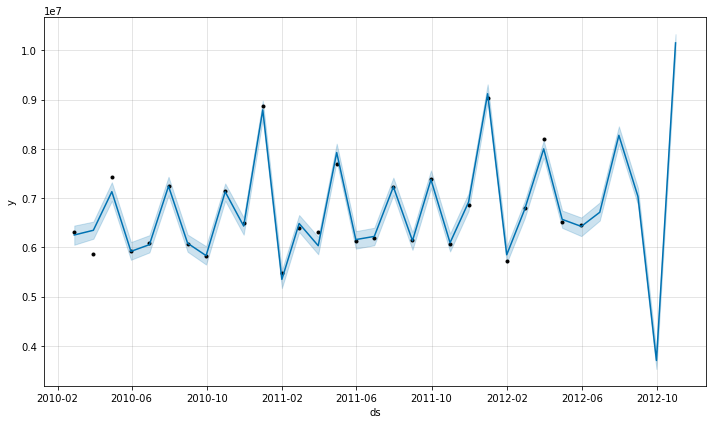

In [323]:
fig1 = m.plot(forecast)

c:\Users\mike_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



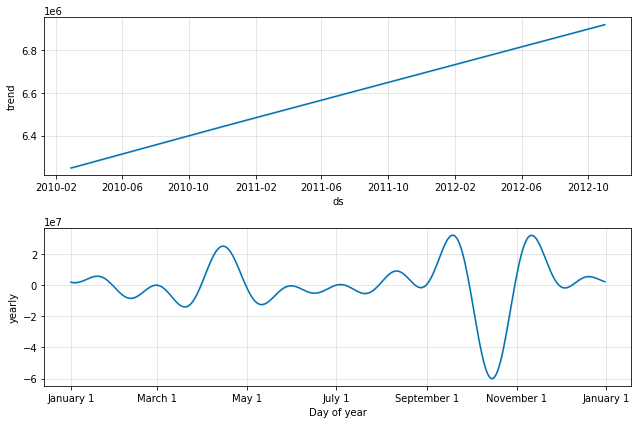

In [324]:
fig2 = m.plot_components(forecast)

In [325]:
fig3 = plot_plotly(m, forecast)
fig3

In [326]:
# model performance
"""
rmse = lambda act, pred: np.sqrt(metrics.mean_squared_error(act, pred))

# Arbitrary data
actual_passengers = [300, 290, 320, 400, 500, 350]
predicted_passengers = [291, 288, 333, 412, 488, 344]

# Error metrics
print(f'RMSE: {rmse(actual_passengers, predicted_passengers)}')
print(f'MAPE: {metrics.mean_absolute_percentage_error(actual_passengers, predicted_passengers)}')
"""
rmse = lambda act, pred: np.sqrt(metrics.mean_squared_error(act, pred))

actual_sales = y_test.values
predicted_sales = forecast.tail()['yhat'].values

print(f'RMSE: {rmse(actual_sales, predicted_sales)}')
print(f'MAPE: {metrics.mean_absolute_percentage_error(actual_sales, predicted_sales)}')

RMSE: 2354248.2024759636
MAPE: 0.3239677688125819


In [327]:
# evaluate metrics
def evaluate(y_true, y_pred):
    dict = {
        'MAE': metrics.mean_absolute_error(y_true, y_pred),
        'MSE': metrics.mean_squared_error(y_true, y_pred),
        'RMSE': math.sqrt(metrics.mean_squared_error(y_true, y_pred)),
        'R2': metrics.r2_score(y_true, y_pred)
        }
    return dict

In [328]:
evaluate(actual_sales, predicted_sales)

{'MAE': 2106897.54075461,
 'MSE': 5542484598861.306,
 'RMSE': 2354248.2024759636,
 'R2': -6.434146497862681}

In [329]:
# Bring graph of Store 1 data
fig = px.line(STORE_1_SERIES, x='ds', y="y",
              labels={
                'ds':'',
                'y':'Sales'
              },
              title='Store 1 Monthly Sales')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['y'] but received: ds

## ++++   Histórico de Ventas

In [ ]:
"""# Train test split Manual
df_train = df[df['ds']<='2019-11-30']
df_test = df[df['ds']>'2019-11-30']
# Print the number of records and date range for training and testing dataset.
print('The training dataset has', len(df_train), 'records, ranging from', df_train['ds'].min(), 'to', df_train['ds'].max())
print('The testing dataset has', len(df_test), 'records, ranging from', df_test['ds'].min(), 'to', df_test['ds'].max())"""

In [ ]:
"""

fig = px.line(df, x='Date', y="Weekly_Sales")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

"""

'\n\nfig = px.line(df, x=\'Date\', y="Weekly_Sales")\n\nfig.update_xaxes(\n    rangeslider_visible=True,\n    rangeselector=dict(\n        buttons=list([\n            dict(count=1, label="1m", step="month", stepmode="backward"),\n            dict(count=6, label="6m", step="month", stepmode="backward"),\n            dict(count=1, label="YTD", step="year", stepmode="todate"),\n            dict(count=1, label="1y", step="year", stepmode="backward"),\n            dict(step="all")\n        ])\n    )\n)\nfig.show()\n\n'

# Next Steps:
## Apply for several models: Semanal a nivel tienda

In [ ]:
# por cada modelo aplicar:
#results = {}
#results_metrics = {}
#for store in df.Store.unique():
#    store_series = df[df['Store'] == store]
#    results[store] = # guardar modelo creado previamente
#    results_metrics[store] = #guardar metricas+performance

    ## formato con pandas


#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

# https://scikit-learn.org/stable/modules/model_evaluation.html

# rmse, mae, mse, mape <- metricas de evaluacion modelos de regresion

# adicional: evaluar modelo en train y test: métricas similares esperadas

# https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series

# https://www.kdnuggets.com/2019/03/beginners-guide-linear-regression-python-scikit-learn.html

# https://www.alpharithms.com/predicting-stock-prices-with-linear-regression-214618/

SyntaxError: invalid syntax (343423073.py, line 6)

In [ ]:
["Hola Mundo %d" % (i + 1) for i in range(10)]